# Decision Trees

Decision trees work in a similar way that 20 Questions does, asking questions that can split the possibilities of a potential guess / prediction.

* Is it above or below this value?
* Is this value True or False?

![20_questions](https://i.ebayimg.com/images/g/-ckAAOSwjfdcUo9G/s-l300.jpg)

In [1]:
import math
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

In [2]:
cat_dog_df = pd.read_csv('cats_n_dogs.csv',index_col='Unnamed: 0')

In [3]:
cat_dog_df

,Plays fetch,Is grumpy,Favorite food,Species
0,True,False,Bacon,Dog
1,False,True,Dog Food,Dog
2,False,True,Cat Food,Cat
3,False,True,Bacon,Cat
4,False,False,Cat Food,Cat
5,False,True,Bacon,Cat
6,False,True,Cat Food,Cat
7,False,False,Dog Food,Dog
8,False,True,Cat Food,Cat
9,True,False,Dog Food,Dog


In [4]:
model = DecisionTreeClassifier(criterion='entropy',presort=True)

X = cat_dog_df.drop('Species',axis=1)
X['Favorite food'] = X['Favorite food'].astype('category').cat.codes
y = cat_dog_df['Species']
X

,Plays fetch,Is grumpy,Favorite food
0,True,False,0
1,False,True,2
2,False,True,1
3,False,True,0
4,False,False,1
5,False,True,0
6,False,True,1
7,False,False,2
8,False,True,1
9,True,False,2


In [5]:
model.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=True, random_state=None,
            splitter='best')

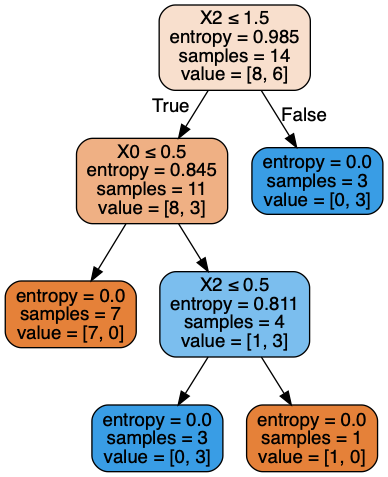

In [6]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# Calculating Information Entropy

* p(x) is the probability of a value (e.g. 0.5 for a coinflip)

![Information Entropy Equation](http://crackingthenutshell.org/wp-content/uploads/file/shannons-formula-small.jpg)

In [7]:
def calc_entropy(number_list):
    '''
    Enter the total of each different class to calculate the information entropy in a node
    Input: list
    Output: Entropy calculation
    '''
    total = sum(number_list)
    entropy = []
    for number in number_list:
        prob = number / total
        ind_prob = prob*math.log(prob,2)
        entropy.append(ind_prob)
    return -sum(entropy)

In [8]:
number_list = [5,5]
calc_entropy(number_list)

1.0

In [9]:
number_list = [80,2]
calc_entropy(number_list)

0.1654270339962668

In [10]:
Counter(cat_dog_df['Species'])

Counter({'Dog': 6, 'Cat': 8})

In [11]:
calc_entropy(list(Counter(cat_dog_df['Species']).values()))

0.9852281360342516

# Calculating Information Gain

* The entropy of the parent node, minus the total of each child nodes entropy multiplied by it's weighted average

![Information Gain](https://www.normshield.com/wp-content/uploads/2017/05/formula1.png)

In [12]:
def calc_info_gain(list_of_3_lists):
    parent_entropy = calc_entropy(list_of_3_lists[0])
    child_entropy1 = calc_entropy(list_of_3_lists[1])
    child_entropy2 = calc_entropy(list_of_3_lists[2])
    weighted_avg1 = sum(list_of_3_lists[1])/sum(list_of_3_lists[0])
    weighted_avg2 = sum(list_of_3_lists[2])/sum(list_of_3_lists[0])
    return parent_entropy - ((child_entropy1*weighted_avg1)+(child_entropy2*weighted_avg2))

Split on 'favorite food is dog food':
* Yes: 3 dogs, 0 cat
* No: 3 dogs, 8 cats

In [13]:
loves_dog_food = [[6,8],[3,0.000000001],[3,8]]
calc_info_gain(loves_dog_food)

0.32102382633626503

Split on 'plays fetch':
* Yes: 4 dogs, 1 cat
* No: 2 dogs, 7 cats

In [14]:
plays_fetch = [[6,8],[4,1],[2,7]]
calc_info_gain(plays_fetch)

0.23612234796179488

Split on 'is grumpy':

* Yes: 4 dogs, 1 cat
* No: 2 dogs, 7 cats

Yes: 2 dogs, 6 cats
No: 4 dogs, 2 cats

In [15]:
is_grumpy = [[6,8],[2,6],[4,2]]
calc_info_gain(is_grumpy)

0.12808527889139454

In [16]:
pd.read_csv('info_gain.csv')

,Split On,Parents Entropy,Child Entropy,Child Entropy.1,Sum_Entropy_x_Weighted Average,Information Gain
0,Plays Fetch,0.9852,0.7642,0.7219,0.7642 * 9/14 + 0.7219 * 5/14 = 0.7491',0.236
1,Is Grumpy,0.9852,0.9183,0.8113,0.9183 * 6/14 + 0.8113 * 8/14 = 0.8571',0.128
2,Loves Dog Food,0.9852,0.8454,0.0000,0.8454 * 11/14 + 0.000 * 3/14 = 0.6642',0.321


# Gini Impurity
* 1 - the sum of each probability squared (e.g. coin flip is 0.5^2 = 0.25)
* Coin flip 1 - ((0.5)^2 + (0.5)^2) = 0.5

* Slightly less computationally expensive since it doesn't use logs

![gini_impurity](https://www.oreilly.com/library/view/advanced-analytics-with/9781491912751/assets/eq_1.png)

# Random Forests

### Decision trees can be very good at predicting the data it's trained on because it can extend its branches to every detail of every data point.  However, it will not generalize as well on data it hasn't seen before; this results in 'overfitting'

### Random Forests do a better job of generalizing on data it hasn't seen before because it uses multiple learners (i.e. decision trees) and averages the predictions of each decision tree.

![random_forest](https://camo.githubusercontent.com/ef7a45dc699e2dd5ffc74eb686d5ce500c34409f/68747470733a2f2f64617461627269636b732e636f6d2f77702d636f6e74656e742f75706c6f6164732f323031352f30312f456e73656d626c652d6578616d706c652e706e67)

### If you just used the same exact decision tree in your random forest, it would be the same as just using one Decision Tree, so to reduce overfitting, you can take random bootstrap samples of your data (i.e. Bagging [Bootstrap Aggregating]) , and take random features on each split

![bagging](https://cdn-images-1.medium.com/max/1600/0*zrm9Q8twgrq8lfLk.)

In [17]:
from sklearn.ensemble import RandomForestClassifier
import shap

In [18]:
def print_score(m):
    train_score = m.score(X_train, y_train)
    test_score =  m.score(X_test, y_test)
    print('Train Accuracy: {}, Test Accuracy: {}'.format(train_score,test_score))
    if hasattr(m, 'oob_score_'):
        print('OOB Score: {}'.format(m.oob_score_))

In [27]:
dt = DecisionTreeClassifier(min_samples_leaf=3, max_features=0.5)
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, 
                            max_features='sqrt', n_jobs=-1, oob_score=True)

In [28]:
X, y = shap.datasets.adult(display=True)
y = np.array([int(label) for label in y])

print(X.shape, y.shape)
X.head()

(32561, 12) (32561,)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [29]:
cat_cols = X.select_dtypes(['category']).columns
X[cat_cols] = X[cat_cols].apply(lambda x: x.cat.codes)
X.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,1,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,0,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,1,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,0,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)

(22792, 12) (9769, 12)


In [31]:
%time dt.fit(X_train,y_train)

CPU times: user 47.3 ms, sys: 3.59 ms, total: 50.9 ms
Wall time: 48.8 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [32]:
%time rf.fit(X_train,y_train)

CPU times: user 2.89 s, sys: 86.5 ms, total: 2.98 s
Wall time: 1.34 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [33]:
print_score(dt)

Train Accuracy: 0.912030537030537, Test Accuracy: 0.8360118742962432


In [34]:
print_score(rf)

Train Accuracy: 0.9051860301860302, Test Accuracy: 0.8645716040536391
OOB Score: 0.8644699894699894
